# Titanic Challenge

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os
for dirname, _, filenames in os.walk('kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

kaggle/input/titanic/test.csv
kaggle/input/titanic/titanic.zip
kaggle/input/titanic/train.csv
kaggle/input/titanic/gender_submission.csv


### Look for columns with missing values

In [2]:
t_train_orig = pd.read_csv("kaggle/input/titanic/train.csv")
t_train_orig.name = "Titanic Training Set"

t_test_orig = pd.read_csv("kaggle/input/titanic/test.csv")
t_test_orig.name = "Titanic Test Set"

def display_missing(df):    
    for col in df.columns.tolist(): 
        if df[col].isnull().sum() > 0:
            print('{} column missing values: {}'.format(col, df[col].isnull().sum()))
    print('\n')

dfs = [t_train_orig, t_test_orig]

display_missing(dfs[0])

for df in dfs:
    print('{}'.format(df.name))
    display_missing(df)

Age column missing values: 177
Cabin column missing values: 687
Embarked column missing values: 2


Titanic Training Set
Age column missing values: 177
Cabin column missing values: 687
Embarked column missing values: 2


Titanic Test Set
Age column missing values: 86
Fare column missing values: 1
Cabin column missing values: 327




In [3]:
# take a look the data
#t_train_orig.describe()

t_train_orig['Died']= t_train_orig['Survived'].map(lambda survived: 0 if survived == 1 else 1)
t_train_orig.groupby('Sex').agg('sum')[['Survived', 'Died']].plot(kind='bar', stacked='true')

# women were much more likely to survive than men

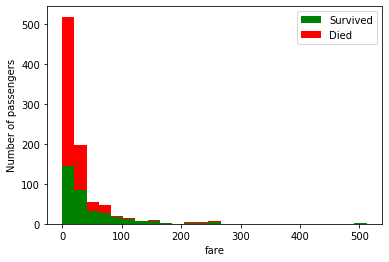

In [4]:
# let's look at the correlation between ticket price and the likelihood of survival

import matplotlib.pyplot as plt
t = t_train_orig
fare_survived =t[t['Survived'] == 1]['Fare'] 
fare_died = t[t['Survived'] == 0]['Fare'] 
plt.hist([fare_survived, fare_died], stacked=True, color = ['g', 'r'], 
         bins = 25, label=['Survived', 'Died'])
plt.xlabel('fare')
plt.ylabel('Number of passengers')
plt.legend()

### See what  Age is correlated with best
so we can fill in nulls with more representative values

In [5]:
t_train_corr= t_train_orig.corr().abs().unstack().sort_values(kind="quicksort", ascending=False).reset_index()
t_train_corr.rename(columns={"level_0": "Feature 1", "level_1": "Feature 2", 0: 'Correlation Coefficient'}, inplace=True)
t_train_corr[t_train_corr["Feature 1"] == "Age"]

t_test_corr = t_train_orig.corr().abs().unstack().sort_values(kind="quicksort", ascending=False).reset_index()
t_test_corr.rename(columns={"level_0": "Feature 1", "level_1": "Feature 2", 0: 'Correlation Coefficient'}, inplace=True)
t_test_corr[t_test_corr["Feature 1"] == "Age"]



,Feature 1,Feature 2,Correlation Coefficient
5,Age,Age,1.000000
15,Age,Pclass,0.369226
20,Age,SibSp,0.308247
28,Age,Parch,0.189119
33,Age,Fare,0.096067
42,Age,Died,0.077221
43,Age,Survived,0.077221
46,Age,PassengerId,0.036847


### Sample training data

In [6]:
t_train_orig.sample(10)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Died
593,594,0,3,"Bourke, Miss. Mary",female,NaN,0,2,364848,7.7500,NaN,Q,1
417,418,1,2,"Silven, Miss. Lyyli Karoliina",female,18.0,0,2,250652,13.0000,NaN,S,0
358,359,1,3,"McGovern, Miss. Mary",female,NaN,0,0,330931,7.8792,NaN,Q,0
604,605,1,1,"Homer, Mr. Harry (""Mr E Haven"")",male,35.0,0,0,111426,26.5500,NaN,C,0
770,771,0,3,"Lievens, Mr. Rene Aime",male,24.0,0,0,345781,9.5000,NaN,S,1
653,654,1,3,"O'Leary, Miss. Hanora ""Norah""",female,NaN,0,0,330919,7.8292,NaN,Q,0
704,705,0,3,"Hansen, Mr. Henrik Juul",male,26.0,1,0,350025,7.8542,NaN,S,1
282,283,0,3,"de Pelsmaeker, Mr. Alfons",male,16.0,0,0,345778,9.5000,NaN,S,1
296,297,0,3,"Hanna, Mr. Mansour",male,23.5,0,0,2693,7.2292,NaN,C,1
460,461,1,1,"Anderson, Mr. Harry",male,48.0,0,0,19952,26.5500,E12,S,0


## Feature exploration

Here are some initial ideas:
* Pclass (1 > 2 > 3)
* Fare ($$ > $)
* Sex (female > male)
* CabinPresent (1 > 0)
* Is child over 12 (1 > 0)


In [7]:
# let's clean-up the data for the decision tree classifier

import math

t_train = t_train_orig

# sex to numeric
t_train['SexNumeric'] = np.where(t_train['Sex'] == "male", 0, 1)

fare_p1 = t_train[t_train['Pclass'] == 1]['Fare'].median()
fare_p2 = t_train[t_train['Pclass'] == 2]['Fare'].median()
fare_p3 = t_train[t_train['Pclass'] == 3]['Fare'].median()
median_fares = [0, fare_p1, fare_p2, fare_p3]

def fare_for_class(row):
    pclass = row['Pclass']
    fare = row['Fare']
    adjusted_fare = median_fares[pclass] if fare == 0 else fare
    return adjusted_fare

t_train['FareAdjusted'] = t_train.apply(fare_for_class,axis=1)

# get average age for different classes
age_p1 = t_train[t_train['Pclass'] == 1]['Age'].median()
age_p2 = t_train[t_train['Pclass'] == 2]['Age'].median()
age_p3 = t_train[t_train['Pclass'] == 3]['Age'].median()
median_ages = [0, age_p1, age_p2, age_p3]

def age_for_class(row):
    pclass = row['Pclass']
    age = row['Age']
    adjusted_age = median_ages[pclass] if np.isnan(age) else age
    return adjusted_age

t_train['AgeAdjusted'] = t_train.apply(age_for_class,axis=1)

# extract titles
get_index = lambda x, xs: [i for (y, i) in zip(xs, range(len(xs))) if x == y][0]

t_train['Title'] = t_train_orig['Name'].map(lambda name: [title for title in name.split(' ') if '.' in title][0])
titles = t_train['Title'].unique()
t_train['TitleNumeric'] = t_train['Title'].map(lambda title: get_index(title, titles))


feature_cols = ['FareAdjusted', 'Pclass', 'SexNumeric', 'TitleNumeric']
t_train[feature_cols].sample(10)

,FareAdjusted,Pclass,SexNumeric,TitleNumeric
802,120.0000,1,0,3
739,7.8958,3,0,0
768,24.1500,3,0,0
280,7.7500,3,0,0
70,10.5000,2,0,0
244,7.2250,3,0,0
723,13.0000,2,0,0
245,90.0000,1,0,6
689,211.3375,1,1,2
151,66.6000,1,1,1


In [8]:
import pandas as pd

from sklearn.tree import DecisionTreeClassifier # Import Decision Tree Classifier
from sklearn.model_selection import train_test_split # Import train_test_split function
from sklearn import metrics #Import scikit-learn metrics module for accuracy calculation

X = t_train[feature_cols]
y = t_train.Survived

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1) # 70% training and 30% test

clf = DecisionTreeClassifier()
clf = clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)

# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.8134328358208955


## Try a random forrest classifier

In [9]:
from sklearn.ensemble import RandomForestClassifier


rfc = RandomForestClassifier(n_estimators=200, min_samples_leaf=3, max_features=0.5, n_jobs=-1)
rfc.fit(X_train,y_train) 

print(f'feature importance: {rfc.feature_importances_}')
print(f'score train: {rfc.score(X_train, y_train)}')
print(f'score:       {rfc.score(X_test, y_test)}')


feature_importances = pd.DataFrame(rfc.feature_importances_,
                                   index = X.columns,
                                    columns=['importance']).sort_values('importance',ascending=False)

feature_importances

feature importance: [0.31836728 0.13769309 0.25097723 0.2929624 ]
score train: 0.8860353130016051
score:       0.8097014925373134


,importance
FareAdjusted,0.318367
TitleNumeric,0.292962
SexNumeric,0.250977
Pclass,0.137693


## Logistic Regression

In [10]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(random_state=0, solver='lbfgs',
                         multi_class='multinomial').fit(X_train, y_train)

prob = lr.predict_proba(X)

print(f'probabilty (count = {len(prob)}\n{prob}\n')
print(f'score: {clf.score(X, y)}')


probabilty (count = 891
[[0.9187709  0.0812291 ]
 [0.10324184 0.89675816]
 [0.39723473 0.60276527]
 ...
 [0.39907669 0.60092331]
 [0.6262236  0.3737764 ]
 [0.91878937 0.08121063]]

score: 0.8900112233445566


In [11]:
# Things I did not use

# passenger has a cabin (if NaN, no cabin)
t_train['CabinPresent'] = t_train['Cabin'].fillna(0)
t_train['CabinPresent'] = np.where(t_train['CabinPresent'] != 0, 1, 0)

# location of cabin.. naive mapping based on the first letter of the Cabin location 
import string
t_train['Deck'] = \
    t_train['Cabin'].map(lambda cabin: cabin[0] if (type(cabin) == str) else "U")

# thought large number of siblings might help (it didn't)
t_train['SibSpLarge'] = t_train['SibSp'].map(lambda ct: 1 if ct > 3 else 0)
#t_train['SibSpLarge'].value_counts()

# people with the same last name may be a family; add feature that represent this count to each person
# doesn't seem to help
t_train['LastName'] = t_train['Name'].map(lambda name: name.split(',')[0])
familyCount = t_train.groupby('LastName')['LastName'].count()
t_train['FamilyCount'] = t_train['LastName'].map(lambda lastName: familyCount[lastName])
t_train['FamilyScore'] = t_train.FamilyCount + t_train.SibSp + t_train.Parch

t_train['FamSize_Single'] = t_train['FamilyScore'].map(lambda score: score == 1)
t_train['FamSize_Small'] = t_train['FamilyScore'].map(lambda score: 1 < score <= 3)
t_train['FamSize_Medium'] = t_train['FamilyScore'].map(lambda score: 3 < score <= 5)
t_train['FamSize_Large'] = t_train['FamilyScore'].map(lambda score: 5 < score)
# next, try using the SibSp to correlate against this count..
# but do people with siblings or spouses have a higher chance of surviving? 

#t_train['Fare'].map(lambda amt: int(amt / 10) * 10).value_counts()
ave_fare = t_train['Fare'].median()
t_train['FareWithDefault'] = t_train['Fare'].map(lambda fare: fare if fare > 0 else ave_fare)


# this actually hurts
t_train['IsChild'] = t_train['AgeAdjusted'].map(lambda age: 1 if (age <= 12.0) else 0)


# extract titles
get_index = lambda x, xs: [i for (y, i) in zip(xs, range(len(xs))) if x == y][0]

t_train['Title'] = t_train_orig['Name'].map(lambda name: [title for title in name.split(' ') if '.' in title][0])
titles = t_train['Title'].unique()

t_train['TitleNumeric'] = t_train['Title'].map(lambda title: get_index(title, titles))

feature_cols = ['FareAdjusted', 'Pclass', 'SexNumeric', 'TitleNumeric']
t_train[feature_cols]

,FareAdjusted,Pclass,SexNumeric,TitleNumeric
0,7.2500,3,0,0
1,71.2833,1,1,1
2,7.9250,3,1,2
3,53.1000,1,1,1
4,8.0500,3,0,0
...,...,...,...,...
886,13.0000,2,0,5
887,30.0000,1,1,2
888,23.4500,3,1,2
889,30.0000,1,0,0
